# Reproducing Fitness Curves

Authors of the studied article also claim that the proposed TS-DE approach outperforms DE in average fitness optimization and is also less sensitive to mutation rate scheduling.


In [1]:
%%time

import sys
import math
from typing import List, Callable

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

sys.path.append('../')

from util.DE.DE import DE
from util.TS_DE.TS_DE import TS_DE
from util.common import zero_population, linear_bayesian_utility_model, random_init_population

CPU times: total: 0 ns
Wall time: 18.3 ms


    **Reproducing right-hand side Figure 6.1.:**

Visualization shows average fitness for different mutation rates in TS-DE, compared to the basic DE approach.

**Parameter setup:**
- *d=10*
- *T=100*
- *M=40* (note that it is unclear what *M* is used in the studied paper)
- *sigma=1*
- *lambda_=1*

**Claims we are testing:**
(2) TS-DE outperforms the basic DE when evaluating average population fitness.
(3) TS-DE is less sensitive to mutation scheduling than the basic DE.

In [2]:
%%time

np.random.seed(seed=0)

# Initial setting for TS-DE and DE
d = 10
M = 40
T = 100
sigma = 1
lambda_ = 1
n_evals = 100

# Theta star - optimal theta - parametrization of the linear Bayesian utility model for
# which we aim to optimize the protein design.
theta_star = np.random.multivariate_normal(np.zeros(d), np.eye(d))
# Evaluations used to visualize average fitness
evaluations = list(range(T))
# To make the code a bit more slick, we save all results to this variable
# This will later be used for visualization
data = []

CPU times: total: 0 ns
Wall time: 500 µs


In [3]:
%%time

# Function returning average fitness for each iteration step (1:T).
def average_fitness(f: Callable[[np.ndarray], float],
                    theta: np.ndarray,
                    S: List[np.ndarray]):
    total_fitness = [f(x, theta) for x in S]
    return sum(total_fitness) / M

CPU times: total: 0 ns
Wall time: 0 ns


### TS-DE curves

As proposed in the article we try different *mu* values (0.2, 0.5, 0.8). For each we calculate average fitness by iteration step (1:T) for the proposed TS-DE approach.

In [4]:
%%time

for i in tqdm(range(n_evals)):
    for mu in [0.2, 0.5, 0.8]:
        populations, _ = TS_DE(d=d,
                               T=T,
                               M=M,
                               theta_star=theta_star,
                               S_0=zero_population(d=d, M=M),
                               mu=mu,
                               sigma=sigma,
                               lambda_=lambda_,
                               f=linear_bayesian_utility_model)
        data.extend([{
            'Setting': f"TS-DE (mu={mu})",
            'T': t,
            'avg. fitness': average_fitness(f=linear_bayesian_utility_model, theta=theta_star, S=S)
        } for t, S in enumerate(populations)])

100%|██████████| 100/100 [05:37<00:00,  3.37s/it]

CPU times: total: 5min 28s
Wall time: 5min 37s


### DE curves

As proposed in the article we try different *mu* values. For each we calculate average fitness by iteration step (1:T) for the proposed DE approach. *mu* values:
- *mu* = 0.1 * 1 / t
- *mu* = 0.5 * 1 / t
- *mu* = 1 / t
- *mu* = 1 / sqrt(t)
- *mu* = 0.5
- *mu* = 0 (random init)


In [5]:
%%time

mu_func = {
    '0.1/(t+1)': lambda t: 0.1 / (t + 1),
    '0.5/(t+1)': lambda t: 0.5 / (t + 1),
    '1/t': lambda t: 1 / (t + 1),
    '1/sqrt(t)': lambda t: 1 / math.sqrt(t + 1),
    '0.5': lambda t: 0.5
}
for i in tqdm(range(n_evals)):
    for mu_func_key in mu_func.keys():
        populations = DE(d=d,
                         T=T,
                         sigma=sigma,
                         theta_star=theta_star,
                         S_0=zero_population(d=d, M=M),
                         mu=mu_func[mu_func_key],
                         f=linear_bayesian_utility_model)
        data.extend([{
            'Setting': f"DE (mu={mu_func_key})",
            'T': t,
            'avg. fitness': average_fitness(f=linear_bayesian_utility_model, theta=theta_star, S=S)
        } for t, S in enumerate(populations)])

100%|██████████| 100/100 [07:23<00:00,  4.43s/it]

CPU times: total: 7min 21s
Wall time: 7min 23s


#### Random init (*mu*=0)

In [6]:
%%time

for i in tqdm(range(n_evals)):
    populations = DE(d=d,
                     T=T,
                     theta_star=theta_star,
                     sigma=sigma,
                     S_0=random_init_population(d=d, M=M),
                     mu=lambda t: 0,
                     f=linear_bayesian_utility_model)

    data.extend([{
        'Setting': f"DE (mu=0 random_init)",
        'T': t,
        'avg. fitness': average_fitness(f=linear_bayesian_utility_model, theta=theta_star, S=S)
    } for t, S in enumerate(populations)])

100%|██████████| 100/100 [00:48<00:00,  2.06it/s]

CPU times: total: 48.3 s
Wall time: 48.6 s


#### Maximal fitness

Maximal is achieved when all motifs are denoted as favorable (=1).

In [7]:
%%time

max_fitness = linear_bayesian_utility_model(
    x=[0 if theta_i < 0 else 1 for theta_i in theta_star],
    theta=theta_star
)

CPU times: total: 0 ns
Wall time: 0 ns


### Visualize results

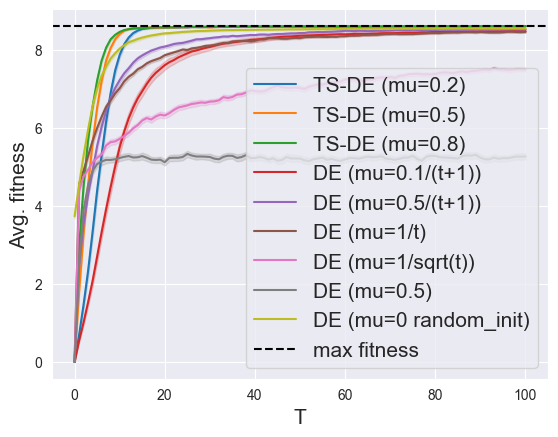

CPU times: total: 12 s
Wall time: 12 s


In [8]:
%%time

plot = sns.lineplot(data=pd.DataFrame(data),
             x='T',
             y='avg. fitness',
             hue='Setting',
             errorbar=('ci', 95))
plt.axhline(y=max_fitness, color='black', label='max fitness', linestyle='--')
plot.set_xlabel('T', fontsize='15')
plot.set_ylabel('Avg. fitness', fontsize='15')

plt.legend(prop={'size': 15})
plt.savefig('../plots/fitness_curves.png')
plt.show()